# Resolving the whole process of plant essential oil dataset
## Load the required packages 

In [1]:
import torch
import seaborn
seaborn.set_context(context="talk")
from GCMSFormer.GCMSformer import train_model, evaluate_model, check_model, plot_loss, make_model
from GCMSFormer.da import gen_datasets
import pickle
from GCMSFormer.Resolution import Resolution, output_msp
from GCMSFormer.Alignment import Alignment
import time
import os
from GCMSFormer.NetCDF import netcdf_reader
import pandas as pd

## Load the Library

In [2]:
with open('./Library/tgt_vacob.pk', 'rb') as file_1:
     tgt_vacob = pickle.load(file_1)

## Load GCMSFormer model 

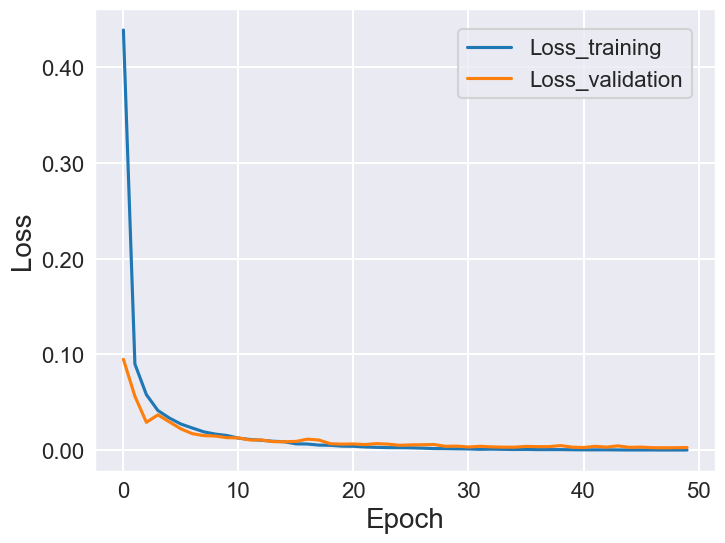

In [4]:
# model and loss can be downloaded in Release  "https://github.com/zxguocsu/GCMSFormer/releases/download/v1.0.0/Model_and_loss.zip"
model_path='./Model_and_loss'
model_name='GCMSFormer'
loss_name='loss'
mz_range = (1, 1000)
if check_model(model_path + '/' + model_name, model_path + '/' + loss_name):
    # load model
    m_state_dict = torch.load(model_path + '/' + model_name + '.pt')
    model = make_model(tgt_vacob, N=3, d_model=1000, d_ff=1024, h=8, dropout=0.1)
    model.load_state_dict(m_state_dict)
    # load loss
    with open(model_path + '/' + loss_name +'.pk', 'rb') as file_1:
         loss = pickle.load(file_1)
    plot_loss(loss)
else:
    para = {'name': 'Library/spectra.msp',   # can be downloaded in Release
            'mz_range': mz_range,
            'aug_num': 100000,
            'layer_num': 3,
            'batch': 20,
            'epoch': 50,
            'lr': 0.0001,
            'head': 8,
            'model_path': model_path,
            'model_name': model_name,
            'loss_name': loss_name}
    # Generating Dataset
    TRAIN, VALID, TEST, tgt_vacob = gen_datasets(para)
    # Train model
    model, Loss = train_model(para,TRAIN, VALID, tgt_vacob)
    plot_loss(Loss) 
    # Test model
    score=evaluate_model(model,TEST,tgt_vacob,int(max(para['mz_range'])))

## GCMSFormer resolution of plant essential oil datasets

In [5]:
# Test GCMSFormer
devices = torch.device('cpu')
model = model.to(devices)
start = time.time()
path = './Essential.Oil.Data'   # can be downloaded in Release  "https://github.com/zxguocsu/GCMSFormer/releases/download/v1.0.0/Essential.Oil.Data.zip"
files = os.listdir(path)
Alignment_or_not = True
if Alignment_or_not:
    df0, N0 = Alignment(path,files,model,tgt_vacob.to(devices),devices)
    df0.to_csv(path + '/' + 'plant essential oil.csv', index=False)
else:
    for filename in files:
        ncr = netcdf_reader(path + '/' + filename, True)
        sta_S, area, rt, R2 = Resolution(path,filename,model,tgt_vacob.to(devices),devices)
        msp = filename.split('.CDF')[0] + '.MSP'
        output_msp(path + '/'+ msp, sta_S, rt)
        csv = filename.split('.CDF')[0] + '.csv'
        df = pd.DataFrame({'rt': rt, 'area': area, 'R2': R2})
        df.to_csv(path + '/' + csv, index = False)
end = time.time()
print("Running time: %.2fs"%(end - start))

1-1.0.CDF: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]


Running time: 67.24s
